# Environmental Effect on Crime

### Imports

In [1]:
import os
import geopandas as gpd
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import descartes
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon

%matplotlib inline

## Location Introduction

### Map of England with London and Essex

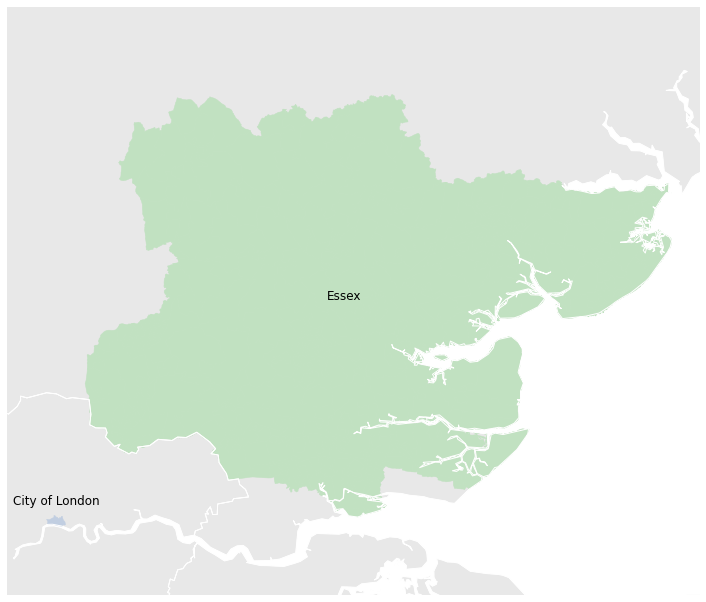

In [491]:
greater_london_shapefile = gpd.read_file('ESRI/London_Borough_Excluding_MHW.shp')
london_shapefile = greater_london_shapefile[greater_london_shapefile['NAME'] == 'City of London']
essex_shapefile = gpd.read_file('Essex County 2021 LSOAs/Essex County 2021 LSOA boundaries.shp')
uk_shapefile = gpd.read_file('NUTS1_Jan_2018_SGCB_in_the_UK_2022_-1211818472919078414/NUTS1_Jan_2018_SGCB_in_the_UK.shp')
england_shapefile = uk_shapefile.query("nuts118cd not in ['UKL', 'UKM', 'UKN']")

fig, ax = plt.subplots(figsize=(10, 10))

england_shapefile.boundary.plot(ax=ax, color='white', linewidth=1)
england_shapefile.plot(ax=ax, facecolor='#e8e8e8', edgecolor='white', linewidth=0.5)

london_shapefile.plot(ax=ax, facecolor='#c1cee1', edgecolor='#c1cee1', linewidth=0.5)
london_centroid = london_shapefile.unary_union.centroid
ax.annotate('City of London', (london_centroid.x, london_centroid.y + 3000), color='black', fontsize=12, ha='center', va='center')

essex_shapefile.plot(ax=ax, facecolor='#c1e1c1', edgecolor='#c1e1c1', linewidth=0.5)
essex_centroid = essex_shapefile.unary_union.centroid
ax.annotate('Essex', (essex_centroid.x, essex_centroid.y), color='black', fontsize=12, ha='center', va='center')

#ax.set_title('Map of England with London and Essex', fontsize=14, fontweight='bold')
ax.set_xlim(525000, 631000)
ax.set_ylim(170000, 260000)
ax.axis('off')

plt.tight_layout()
plt.show()


### Population and Area

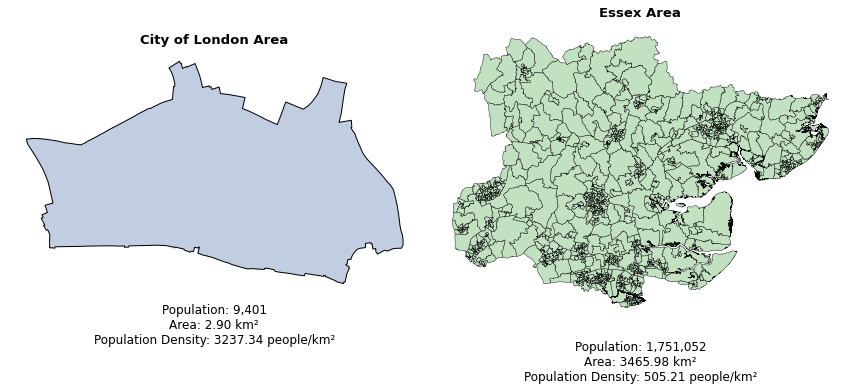

In [428]:
london_population = 9401
essex_population = 1751052

london_area = london_shapefile['geometry'].unary_union.area / 10**6
essex_area = essex_shapefile['geometry'].unary_union.area / 10**6

london_population_density = london_population / london_area
essex_population_density = essex_population / essex_area

scale_factor = essex_area / london_area

fig, axs = plt.subplots(1, 2, figsize=(12, 4 * (scale_factor/6)))

london_shapefile.plot(ax=axs[0], facecolor='#c1cee1', edgecolor='black')
axs[0].set_title('City of London Area', fontweight='bold')
axs[0].set_aspect('equal')
axs[0].axis('off')
axs[0].annotate(f'Population: {london_population:,}\nArea: {london_area:.2f} km²\nPopulation Density: {london_population_density:.2f} people/km²', xy=(0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=12)

essex_shapefile.plot(ax=axs[1], facecolor='#c1e1c1', edgecolor='black', linewidth=0.4)
axs[1].set_title('Essex Area', fontweight='bold', y=1)
axs[1].set_aspect('equal')
axs[1].axis('off')
axs[1].annotate(f'Population: {essex_population:,}\nArea: {essex_area:.2f} km²\nPopulation Density: {essex_population_density:.2f} people/km²', xy=(0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


## The Dataset

### Crime Data
Recorded during the month of November, 2022

In [377]:
london_crime_data = pd.read_csv('2022-11-city-of-london-street.csv')
essex_crime_data = pd.read_csv('2022-11-essex-street.csv')

london_crime_data = london_crime_data.drop(columns='Context')
essex_crime_data = essex_crime_data.drop(columns='Context')

print("London Crime Data (2022-11):")
display(london_crime_data.sample(5))

print("\nEssex Crime Data (2022-11):")
display(essex_crime_data.sample(5))

London Crime Data (2022-11):


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
10,NaN,2022-11,City of London Police,City of London Police,-0.097070,51.518892,On or near Aldersgate Street,E01000001,City of London 001A,Anti-social behaviour,NaN
95,f27a794e66a49d4fefa01fdc1b036c3a4fc6cbd091a1ed...,2022-11,City of London Police,City of London Police,-0.075401,51.511164,On or near,E01000005,City of London 001E,Other theft,Status update unavailable
664,954ce0610b03513b97e137c6ba8360a0bf20a5a78dc33b...,2022-11,City of London Police,City of London Police,-0.106076,51.517239,On or near,E01032740,City of London 001G,Theft from the person,Investigation complete; no suspect identified
544,fab3f8ef841bb3833977fc2e9c889ab78de53294c8fd89...,2022-11,City of London Police,City of London Police,-0.081091,51.508820,On or near Water Lane,E01032739,City of London 001F,Violence and sexual offences,Unable to prosecute suspect
5,88fd7cdb3dbe83eb507cffdf20583ec95262cd90c57414...,2022-11,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Investigation complete; no suspect identified



Essex Crime Data (2022-11):


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
8688,a57f3b455972f459ffe83da612563936a1b5498555c6a2...,2022-11,Essex Police,Essex Police,0.120362,51.753936,On or near Upper Mealines,E01021837,Harlow 008E,Vehicle crime,Investigation complete; no suspect identified
12825,629c4bcf230e81fef7d2a4ced538254d7ae44cd29a80b0...,2022-11,Essex Police,Essex Police,0.298017,51.524471,On or near,E01015971,Thurrock 006B,Other theft,Investigation complete; no suspect identified
13325,8b616309f85bc21664dc0823de14394db6de13ca7fea81...,2022-11,Essex Police,Essex Police,0.283058,51.486555,On or near,E01016011,Thurrock 015B,Other theft,Unable to prosecute suspect
8058,2d73bbac907be51236372a8b39a66df76454fc2fc8b22a...,2022-11,Essex Police,Essex Police,0.116622,51.769713,On or near Tunnmeade,E01021846,Harlow 002C,Burglary,Investigation complete; no suspect identified
4232,ffb0ddc1e56f00a66863fad7159d0a4c15d402fae21ddb...,2022-11,Essex Police,Essex Police,0.459238,51.748788,On or near Tennyson Road,E01021576,Chelmsford 006A,Criminal damage and arson,Investigation complete; no suspect identified


## Amount of Crime Per Location

### Total

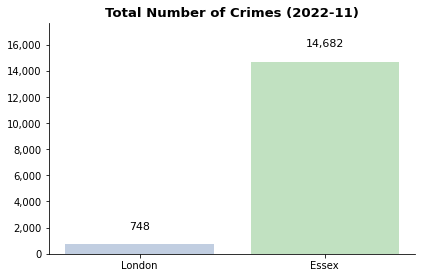

In [473]:
london_total_crimes = london_crime_data.shape[0]
essex_total_crimes = essex_crime_data.shape[0]

locations = ['London', 'Essex']
totals = [london_total_crimes, essex_total_crimes]

colors = ['#c1cee1', '#c1e1c1']

plt.bar(locations, totals, color=colors)
plt.title('Total Number of Crimes (2022-11)', fontweight='bold')

for i, total in enumerate(totals):
    formatted_total = "{:,}".format(total)
    plt.text(i, total + 1000, formatted_total, ha='center', va='bottom')

plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.ylim(0, max(totals) + 3000)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Per 1000 People

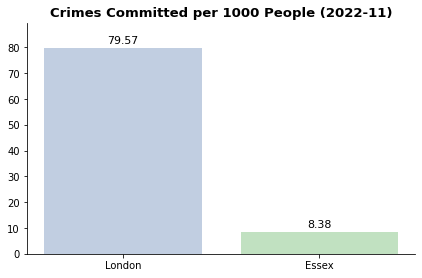

In [474]:
london_population = 9401
essex_population = 1751052

london_crimes_per_1000 = (london_total_crimes / london_population) * 1000
essex_crimes_per_1000 = (essex_total_crimes / essex_population) * 1000

locations = ['London', 'Essex']
crimes_per_1000 = [london_crimes_per_1000, essex_crimes_per_1000]

colors = ['#c1cee1', '#c1e1c1']

plt.bar(locations, crimes_per_1000, color=colors)
plt.title('Crimes Committed per 1000 People (2022-11)', fontweight='bold')

for i, value in enumerate(crimes_per_1000):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', va='bottom')

plt.ylim(0, max(crimes_per_1000) + 10)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Plotted Crime Occurrences

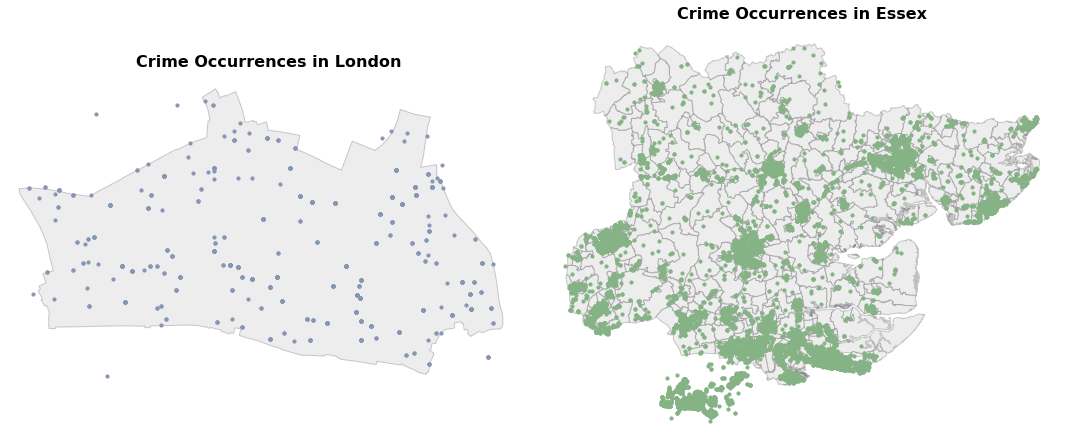

In [492]:
london_geometry = [Point(xy) for xy in zip(london_crime_data['Longitude'], london_crime_data['Latitude'])]
essex_geometry = [Point(xy) for xy in zip(essex_crime_data['Longitude'], essex_crime_data['Latitude'])]

crs = 'EPSG:4326'
london_geo_df = gpd.GeoDataFrame(london_crime_data, crs=crs, geometry=london_geometry)
essex_geo_df = gpd.GeoDataFrame(essex_crime_data, crs=crs, geometry=essex_geometry)

london_geo_df = london_geo_df.to_crs(london_shapefile.crs)
essex_geo_df = essex_geo_df.to_crs(essex_shapefile.crs)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

london_shapefile.plot(ax=axs[0], alpha=0.4, color='lightgrey', edgecolor='grey')
london_geo_df.plot(ax=axs[0], markersize=10, color='#8697b3')
axs[0].set_title('Crime Occurrences in London', fontsize=16, fontweight='bold')
axs[0].set_xlim(530900, 534000)
axs[0].set_ylim(180400, 182300)
axs[0].axis('off')

essex_shapefile.plot(ax=axs[1], alpha=0.4, color='lightgrey', edgecolor='grey')
essex_geo_df.plot(ax=axs[1], markersize=10, color='#86b386')
axs[1].set_title('Crime Occurrences in Essex', fontsize=16, fontweight='bold')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Types of Crime Committed

In [469]:
london_unique_crimes = london_crime_data['Crime type'].unique()
essex_unique_crimes = essex_crime_data['Crime type'].unique()

all_crimes = set(london_unique_crimes) | set(essex_unique_crimes)

sorted_crimes = sorted(list(all_crimes))

print("\033[1mCrime Types:\033[0m")
for crime_type in sorted_crimes:
    print("•", crime_type)

Crime Types:
• Anti-social behaviour
• Bicycle theft
• Burglary
• Criminal damage and arson
• Drugs
• Other crime
• Other theft
• Possession of weapons
• Public order
• Robbery
• Shoplifting
• Theft from the person
• Vehicle crime
• Violence and sexual offences


### Crime Type Distribution

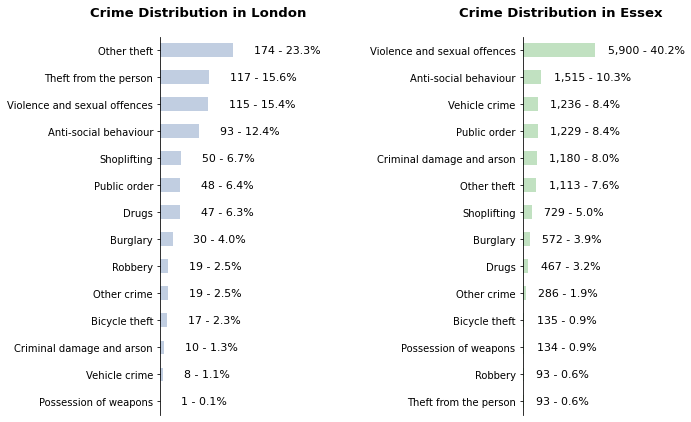

In [402]:
london_crime_counts = london_crime_data['Crime type'].value_counts()
essex_crime_counts = essex_crime_data['Crime type'].value_counts()

plt.rcParams['font.size'] = 11  
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
london_crime_counts_sorted = london_crime_counts.sort_values()
london_crime_counts_sorted.plot(kind='barh', color='#c1cee1')
plt.title('Crime Distribution in London', pad=20, fontweight='bold')
plt.xlabel('Number of Crimes')
plt.gca().axes.get_xaxis().set_visible(False)

for index, value in enumerate(london_crime_counts_sorted):
    plt.text(value + 50, index, f'{value:,} - {value / london_crime_counts.sum() * 100:.1f}%', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplot(1, 2, 2)
essex_crime_counts_sorted = essex_crime_counts.sort_values()
essex_crime_counts_sorted.plot(kind='barh', color='#c1e1c1')
plt.title('Crime Distribution in Essex', pad=20, fontweight='bold')
plt.xlabel('Number of Crimes')
plt.gca().axes.get_xaxis().set_visible(False)

for index, value in enumerate(essex_crime_counts_sorted):
    plt.text(value + 1000, index, f'{value:,} - {value / essex_crime_counts.sum() * 100:.1f}%', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
plt.show()


### Plotted Crime Type Distribution

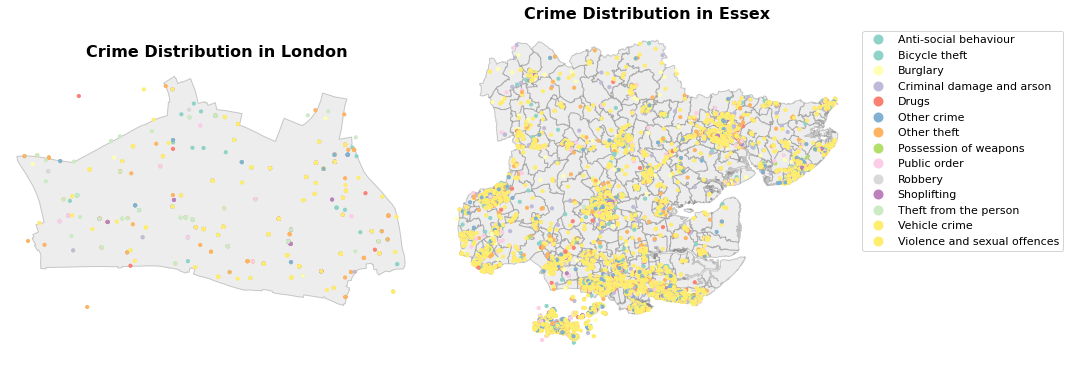

In [484]:
london_geometry = [Point(xy) for xy in zip(london_crime_data['Longitude'], london_crime_data['Latitude'])]
essex_geometry = [Point(xy) for xy in zip(essex_crime_data['Longitude'], essex_crime_data['Latitude'])]

crs = 'EPSG:4326'
london_geo_df = gpd.GeoDataFrame(london_crime_data, crs=crs, geometry=london_geometry)
essex_geo_df = gpd.GeoDataFrame(essex_crime_data, crs=crs, geometry=essex_geometry)

london_geo_df = london_geo_df.to_crs(london_shapefile.crs)
essex_geo_df = essex_geo_df.to_crs(essex_shapefile.crs)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

london_shapefile.plot(ax=axs[0], alpha=0.4, color='lightgrey', edgecolor='grey')
london_geo_df.plot(ax=axs[0], markersize=10, column='Crime type', cmap='Set3')
axs[0].set_title('Crime Distribution in London', fontsize=16, fontweight='bold')
axs[0].set_xlim(530900, 534000)
axs[0].set_ylim(180400, 182300)
axs[0].axis('off')

essex_shapefile.plot(ax=axs[1], alpha=0.4, color='lightgrey', edgecolor='grey')
essex_geo_df.plot(ax=axs[1], markersize=10, column='Crime type', legend=True, cmap='Set3')
axs[1].get_legend().set_bbox_to_anchor((1, 1))
axs[1].set_title('Crime Distribution in Essex', fontsize=16, fontweight='bold')
axs[1].axis('off')

plt.tight_layout()
plt.show()


## Crime Outcomes

In [299]:
london_unique_outcomes = london_crime_data['Last outcome category'].unique()
essex_unique_outcomes = essex_crime_data['Last outcome category'].unique()

london_unique_outcomes = [str(outcome) for outcome in london_unique_outcomes]
essex_unique_outcomes = [str(outcome) for outcome in essex_unique_outcomes]

all_outcomes = set(london_unique_outcomes) | set(essex_unique_outcomes)

sorted_outcomes = sorted(list(all_outcomes))

sorted_outcomes = [outcome for outcome in sorted_outcomes if pd.notnull(outcome)]

print("\033[1mOutcome Types:\033[0m")
for outcome_type in sorted_outcomes:
    print("•", outcome_type)


Outcome Types:
• Action to be taken by another organisation
• Awaiting court outcome
• Court result unavailable
• Formal action is not in the public interest
• Further action is not in the public interest
• Further investigation is not in the public interest
• Investigation complete; no suspect identified
• Local resolution
• Offender given a caution
• Status update unavailable
• Suspect charged as part of another case
• Unable to prosecute suspect
• nan


### Outcome Type Distribution

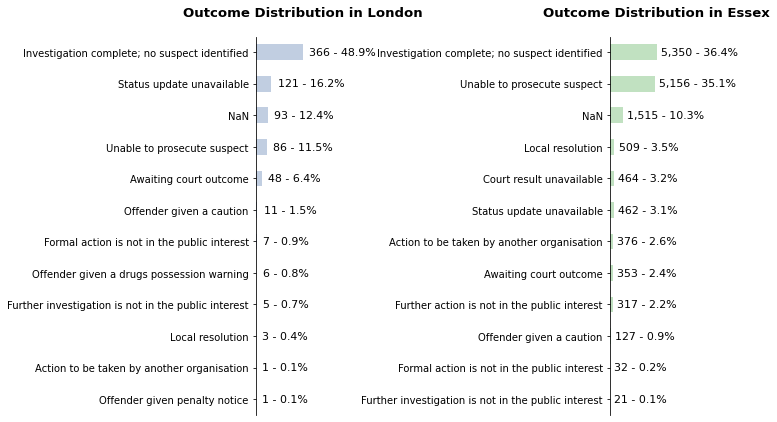

In [446]:
london_outcome_counts = london_crime_data['Last outcome category'].value_counts()
essex_outcome_counts = essex_crime_data['Last outcome category'].value_counts()

london_outcome_counts.loc['NaN'] = london_crime_data['Last outcome category'].isna().sum()
essex_outcome_counts.loc['NaN'] = essex_crime_data['Last outcome category'].isna().sum()

plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
london_outcome_counts_sorted = london_outcome_counts.sort_values()
london_outcome_counts_sorted.plot(kind='barh', color='#c1cee1')
plt.title('Outcome Distribution in London', pad=20, fontweight='bold')
plt.xlabel('Number of Outcomes')
plt.gca().axes.get_xaxis().set_visible(False)

plt.xlim(0, max(london_outcome_counts_sorted) * 2)

for index, value in enumerate(london_outcome_counts_sorted):
    plt.text(value + 50, index, f'{value:,} - {value / london_outcome_counts.sum() * 100:.1f}%', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplot(1, 2, 2)
essex_outcome_counts_sorted = essex_outcome_counts.sort_values()
essex_outcome_counts_sorted.plot(kind='barh', color='#c1e1c1')
plt.title('Outcome Distribution in Essex', pad=20, fontweight='bold')
plt.xlabel('Number of Outcomes')
plt.gca().axes.get_xaxis().set_visible(False)

plt.xlim(0, max(essex_outcome_counts_sorted) * 2)

for index, value in enumerate(essex_outcome_counts_sorted):
    plt.text(value + 500, index, f'{value:,} - {value / essex_outcome_counts.sum() * 100:.1f}%', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=1)

plt.tight_layout()
plt.show()

### Categorised Outcomes

In [418]:
outcome_categories = {
    'Charged / Resolved': [
        'Local resolution',
        'Offender given a caution',
        'Offender given a drugs possession warning',
        'Offender given penalty notice',
        'Suspect charged as part of another case'
    ],
    'Not Charged / Unresolved': [
        'Investigation complete; no suspect identified',
        'Unable to prosecute suspect'
    ],
    'Pending': [
        'Action to be taken by another organisation',
        'Awaiting court outcome'
    ],
    'Unknown': [
        'NaN',
        'Status update unavailable',
        'Formal action is not in the public interest',
        'Further action is not in the public interest',
        'Court result unavailable',
        'Further investigation is not in the public interest'
    ]
}

outcomes_df = pd.DataFrame.from_dict(outcome_categories, orient='index').transpose()
outcomes_df = outcomes_df.fillna('')
outcomes_df.to_csv('crime_outcomes.csv', index=False)

outcomes_df.head()


,Charged / Resolved,Not Charged / Unresolved,Pending,Unknown
0,Local resolution,Investigation complete; no suspect identified,Action to be taken by another organisation,NaN
1,Offender given a caution,Unable to prosecute suspect,Awaiting court outcome,Status update unavailable
2,Offender given a drugs possession warning,,,Formal action is not in the public interest
3,Offender given penalty notice,,,Further action is not in the public interest
4,Suspect charged as part of another case,,,Court result unavailable


### Categorised Outcome Distribution

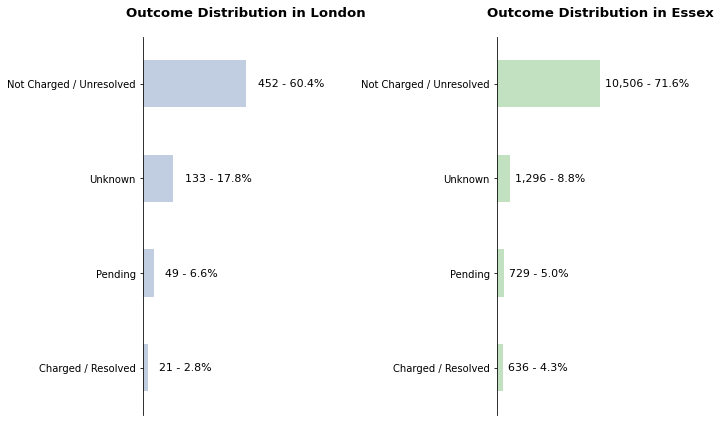

In [420]:
london_outcome_counts = {}
london_outcome_percentages = {}
for category, outcomes in outcome_categories.items():
    count = london_crime_data['Last outcome category'].isin(outcomes).sum()
    percentage = count / len(london_crime_data) * 100
    london_outcome_counts[category] = count
    london_outcome_percentages[category] = percentage

essex_outcome_counts = {}
essex_outcome_percentages = {}
for category, outcomes in outcome_categories.items():
    count = essex_crime_data['Last outcome category'].isin(outcomes).sum()
    percentage = count / len(essex_crime_data) * 100
    essex_outcome_counts[category] = count
    essex_outcome_percentages[category] = percentage

plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
london_outcome_counts_sorted = pd.Series(london_outcome_counts).sort_values()
london_outcome_counts_sorted.plot(kind='barh', color='#c1cee1')
plt.title('Outcome Distribution in London', pad=20, fontweight='bold')
plt.xlabel('Number of Outcomes')
plt.gca().axes.get_xaxis().set_visible(False)

plt.xlim(0, max(london_outcome_counts_sorted) * 2)

for index, value in enumerate(london_outcome_counts_sorted):
    plt.text(value + 50, index, f'{value:,} - {london_outcome_percentages[london_outcome_counts_sorted.index[index]]:.1f}%', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplot(1, 2, 2)
essex_outcome_counts_sorted = pd.Series(essex_outcome_counts).sort_values()
essex_outcome_counts_sorted.plot(kind='barh', color='#c1e1c1')
plt.title('Outcome Distribution in Essex', pad=20, fontweight='bold')
plt.xlabel('Number of Outcomes')
plt.gca().axes.get_xaxis().set_visible(False)

plt.xlim(0, max(essex_outcome_counts_sorted) * 2)

for index, value in enumerate(essex_outcome_counts_sorted):
    plt.text(value + 500, index, f'{value:,} - {essex_outcome_percentages[essex_outcome_counts_sorted.index[index]]:.1f}%', va='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=1)

plt.tight_layout()
plt.show()
